## Bayesian Neural Network design and inference for regression application using the oceanographic data ##


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
!pip install torchbnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

import torchbnn as bnn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [6]:
bottle_dataset_path = "/content/gdrive/MyDrive/oceanographic_data/bottle.csv"

cast_dataset_path = "/content/gdrive/MyDrive/oceanographic_data/cast.csv"

In [7]:
bottle_df = pd.read_csv(bottle_dataset_path)

cast_df = pd.read_csv(cast_dataset_path)

<ipython-input-7-edef5146ed16>:1: DtypeWarning: Columns (47,73) have mixed types. Specify dtype option on import or set low_memory=False.
  bottle_df = pd.read_csv(bottle_dataset_path)
<ipython-input-7-edef5146ed16>:3: DtypeWarning: Columns (40,41,44,45,46,47) have mixed types. Specify dtype option on import or set low_memory=False.
  cast_df = pd.read_csv(cast_dataset_path)


## Exploratory Data Analysis (EDA)

In [8]:
bottle_df.head()

,Cst_Cnt,Btl_Cnt,Sta_ID,Depth_ID,Depthm,T_degC,Salnty,O2ml_L,STheta,O2Sat,...,R_PHAEO,R_PRES,R_SAMP,DIC1,DIC2,TA1,TA2,pH2,pH1,DIC Quality Comment
0,1,1,054.0 056.0,19-4903CR-HY-060-0930-05400560-0000A-3,0,10.50,33.440,NaN,25.649,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2,054.0 056.0,19-4903CR-HY-060-0930-05400560-0008A-3,8,10.46,33.440,NaN,25.656,NaN,...,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,3,054.0 056.0,19-4903CR-HY-060-0930-05400560-0010A-7,10,10.46,33.437,NaN,25.654,NaN,...,NaN,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,4,054.0 056.0,19-4903CR-HY-060-0930-05400560-0019A-3,19,10.45,33.420,NaN,25.643,NaN,...,NaN,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,5,054.0 056.0,19-4903CR-HY-060-0930-05400560-0020A-7,20,10.45,33.421,NaN,25.643,NaN,...,NaN,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# Depth ID conversion into month/date

# Define a function to perform the conversion
def convert_depthID_to_date(row):
    # Extract the desired portion
    desired_part = row[:7]

    # Split the extracted part into century, year, and month
    century = int(desired_part[:2])
    year = int(desired_part[3:5])
    month = int(desired_part[5:])

    # Convert to datetime object
    date_obj = datetime.datetime(year + century * 100, month, 1)

    # Format the date as 'MM/YYYY'
    formatted_date = date_obj.strftime('%m/%Y')

    return formatted_date

# Apply the conversion function to the column
bottle_df['Formatted_Date'] = bottle_df['Depth_ID'].apply(convert_depthID_to_date)

print(bottle_df['Formatted_Date'])

0         03/1949
1         03/1949
2         03/1949
3         03/1949
4         03/1949
           ...   
864858    11/2016
864859    11/2016
864860    11/2016
864861    11/2016
864862    11/2016
Name: Formatted_Date, Length: 864863, dtype: object


In [11]:
bottle_df.shape

(864863, 75)

In [12]:
bottle_df.describe()

,Cst_Cnt,Btl_Cnt,Depthm,T_degC,Salnty,O2ml_L,STheta,O2Sat,Oxy_µmol/Kg,BtlNum,...,R_CHLA,R_PHAEO,R_PRES,R_SAMP,DIC1,DIC2,TA1,TA2,pH2,pH1
count,864863.000000,864863.000000,864863.000000,853900.000000,817509.000000,696201.000000,812174.000000,661274.000000,661268.000000,118667.000000,...,225276.000000,225275.000000,864863.000000,122006.000000,1999.000000,224.000000,2084.000000,234.000000,10.000000,84.000000
mean,17138.790958,432432.000000,226.831951,10.799677,33.840350,3.392468,25.819394,57.103779,148.808694,10.497426,...,0.450225,0.198599,228.395694,162.071521,2153.239714,2168.148330,2256.055845,2278.858803,7.948570,7.910983
std,10240.949817,249664.587269,316.050259,4.243825,0.461843,2.073256,1.167787,37.094137,90.187533,6.189688,...,1.208566,0.376539,319.456731,85.722796,112.995202,154.852332,34.844435,58.496495,0.021216,0.077666
min,1.000000,1.000000,0.000000,1.440000,28.431000,-0.010000,20.934000,-0.100000,-0.434900,0.000000,...,-0.010000,-3.890000,0.000000,0.000000,1948.850000,1969.440000,2181.570000,2198.150000,7.923100,7.618300
25%,8269.000000,216216.500000,46.000000,7.680000,33.488000,1.360000,24.965000,21.100000,60.915470,5.000000,...,0.050000,0.050000,46.000000,200.000000,2028.330000,2008.977500,2230.322500,2229.062500,7.931475,7.898675
50%,16848.000000,432432.000000,125.000000,10.060000,33.863000,3.440000,25.996000,54.400000,151.064150,10.000000,...,0.160000,0.110000,126.000000,206.000000,2170.640000,2265.885000,2244.325000,2247.505000,7.946650,7.928850
75%,26557.000000,648647.500000,300.000000,13.880000,34.196900,5.500000,26.646000,97.600000,240.379600,16.000000,...,0.390000,0.230000,302.000000,214.000000,2253.810000,2315.525000,2278.505000,2316.452500,7.963300,7.955100
max,34404.000000,864863.000000,5351.000000,31.140000,37.034000,11.130000,250.784000,214.100000,485.701800,25.000000,...,66.110000,65.300000,5458.000000,424.000000,2367.800000,2364.420000,2434.900000,2437.000000,7.988300,8.047700


In [13]:
bottle_df.dtypes

Cst_Cnt                  int64
Btl_Cnt                  int64
Sta_ID                  object
Depth_ID                object
Depthm                   int64
                        ...   
TA2                    float64
pH2                    float64
pH1                    float64
DIC Quality Comment     object
Formatted_Date          object
Length: 75, dtype: object

In [14]:
bottle_df.dtypes.value_counts()

float64    65
int64       5
object      5
dtype: int64

In [11]:
object_columns = bottle_df.select_dtypes(include='object').columns
print(object_columns)

Index(['Sta_ID', 'Depth_ID', 'IncTim', 'DIC Quality Comment'], dtype='object')


In [13]:
int_columns = bottle_df.select_dtypes(include='int64').columns
print(int_columns)

Index(['Cst_Cnt', 'Btl_Cnt', 'Depthm', 'RecInd', 'R_PRES'], dtype='object')


In [15]:
# Check for missing values in the dataset
bottle_df.isnull().sum()

Cst_Cnt                     0
Btl_Cnt                     0
Sta_ID                      0
Depth_ID                    0
Depthm                      0
                        ...  
TA1                    862779
TA2                    864629
pH2                    864853
pH1                    864779
DIC Quality Comment    864808
Length: 74, dtype: int64

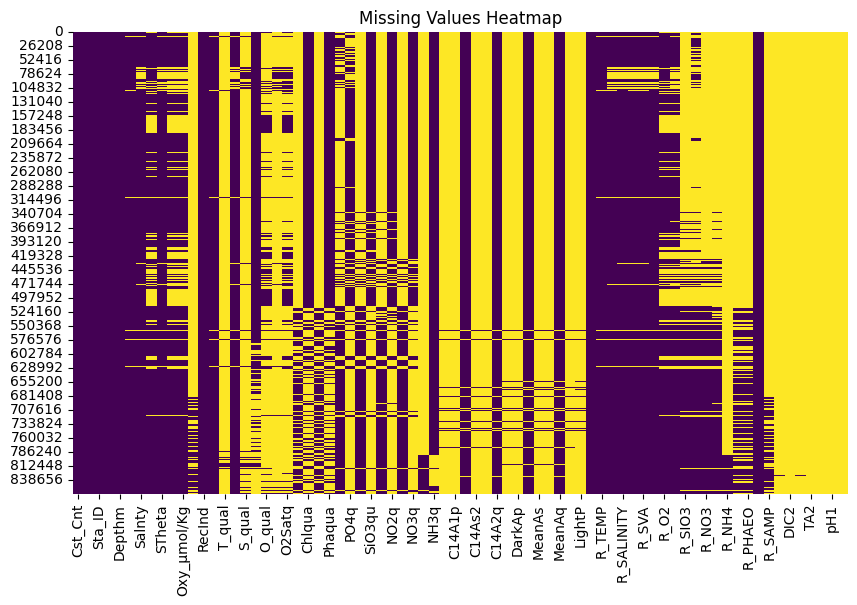

In [16]:
plt.figure(figsize=(10, 6))
sns.heatmap(bottle_df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

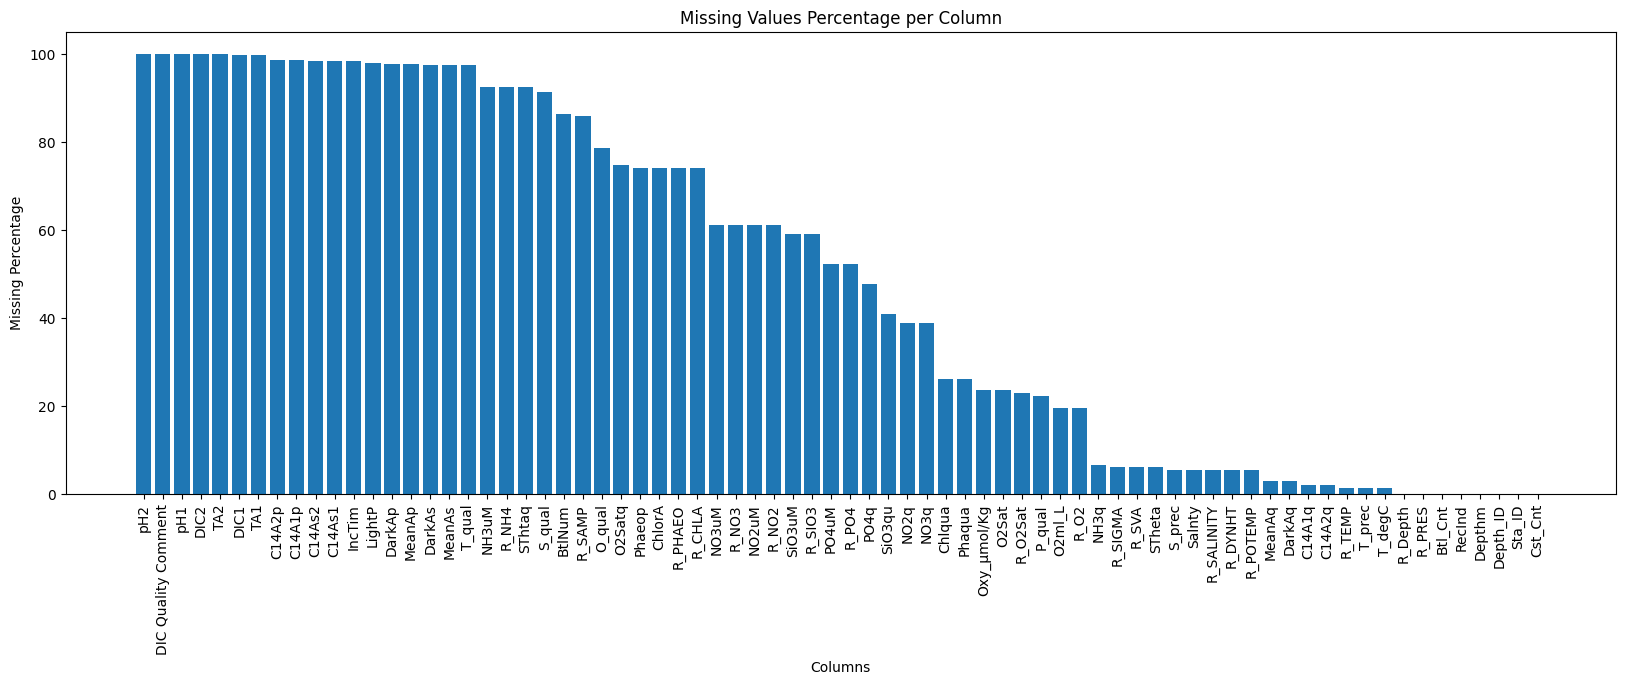

In [19]:
# Calculate the percentage of missing values in each column
missing_percentages = bottle_df.isnull().mean() * 100

# Create a DataFrame to store the missing value percentages
missing_df = pd.DataFrame(missing_percentages, columns=['Missing Percentage'])

# Sort the DataFrame by missing percentage in descending order
missing_df = missing_df.sort_values(by='Missing Percentage', ascending=False)

# Plot the missing value percentages
plt.figure(figsize=(20, 6))
plt.bar(missing_df.index, missing_df['Missing Percentage'])
plt.xlabel('Columns')
plt.ylabel('Missing Percentage')
plt.title('Missing Values Percentage per Column')
plt.xticks(rotation=90)
plt.show()

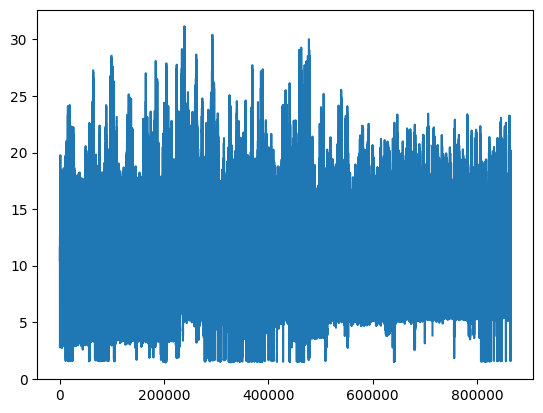

In [20]:
plt.plot(bottle_df['T_degC'])

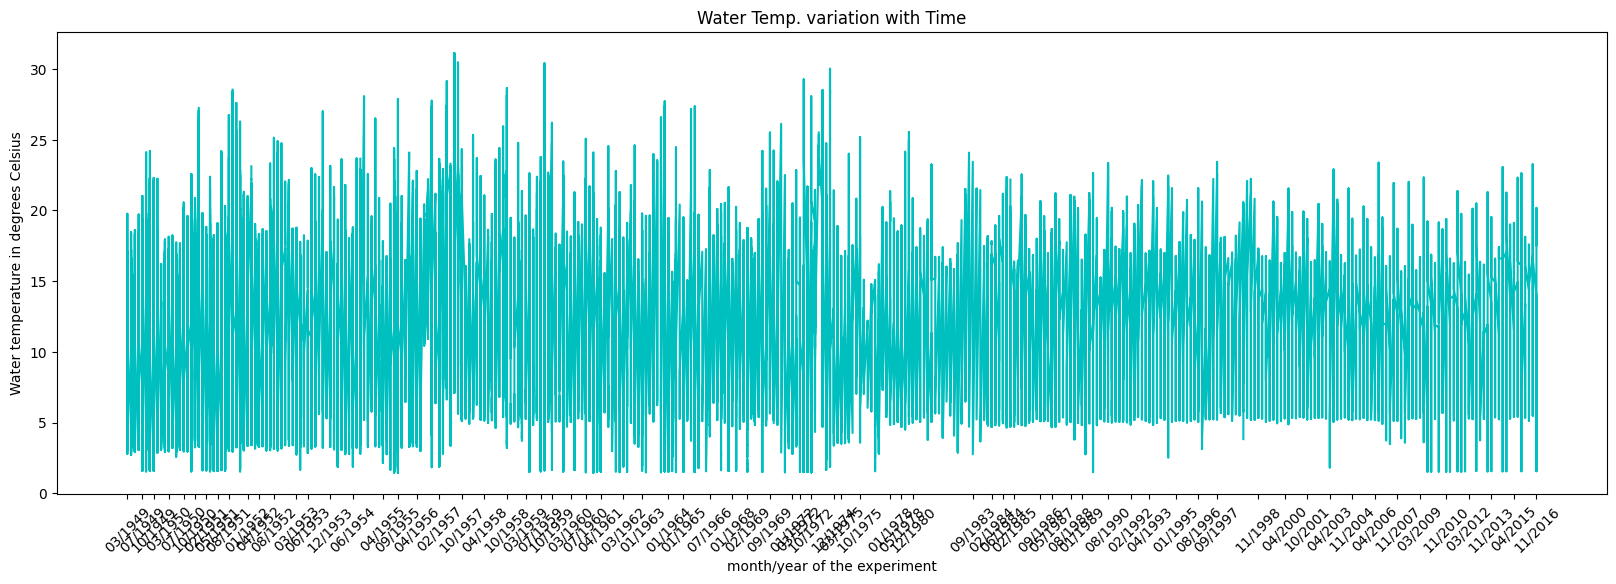

In [29]:
# Line plot of a time series variable
plt.figure(figsize=(20, 6))
plt.plot(bottle_df['Formatted_Date'], bottle_df['T_degC'], color='c')

# Set the x-ticks to display legends for every 12000th data point
x_ticks = bottle_df['Formatted_Date'].iloc[::12000]  # Select every 12000th value
plt.xticks(x_ticks, rotation=45)

plt.xlabel('month/year of the experiment')
plt.ylabel('Water temperature in degrees Celsius')
plt.title('Water Temp. variation with Time')
plt.show()

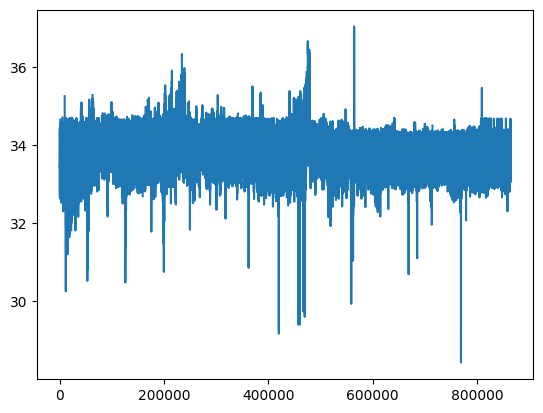

In [21]:
plt.plot(bottle_df['Salnty'])

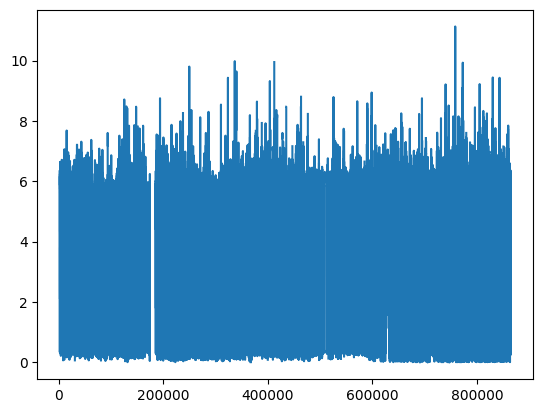

In [22]:
plt.plot(bottle_df['O2ml_L'])

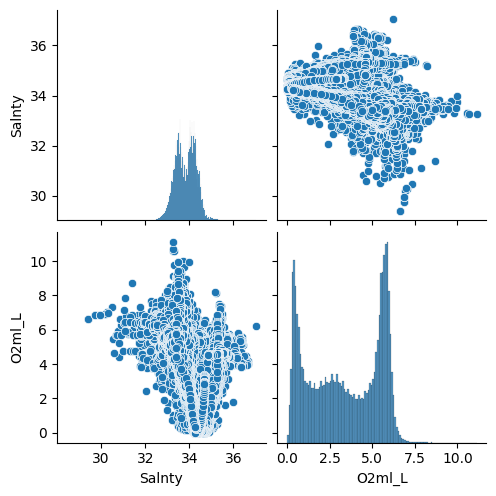

In [30]:
# Pairwise scatter plot of numerical variables
sns.pairplot(bottle_df, vars=['Salnty', 'O2ml_L'])
plt.show()

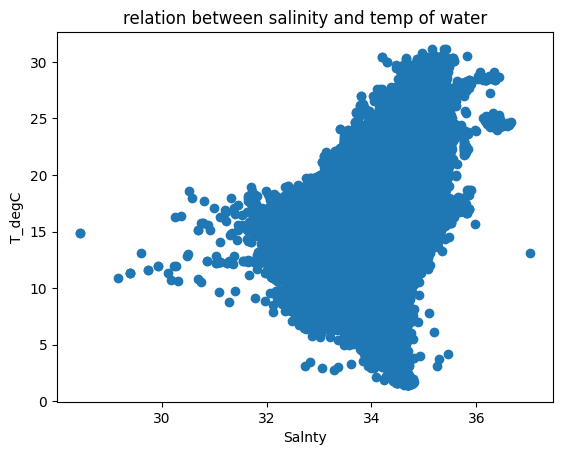

In [60]:
# Scatter plot to understand the relation and identify outliers in two variables
plt.scatter(bottle_df['Salnty'], bottle_df['T_degC'])
plt.xlabel('Salnty')
plt.ylabel('T_degC')
plt.title('relation between salinity and temp of water')
plt.show()

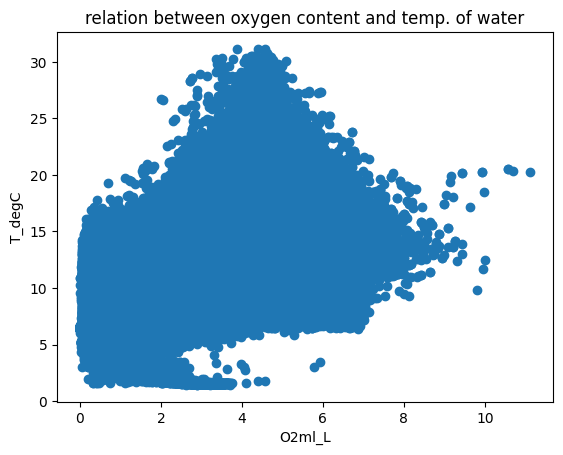

In [61]:
# Scatter plot to understand the relation and identify outliers in two variables
plt.scatter(bottle_df['O2ml_L'], bottle_df['T_degC'])
plt.xlabel('O2ml_L')
plt.ylabel('T_degC')
plt.title('relation between oxygen content and temp. of water')
plt.show()

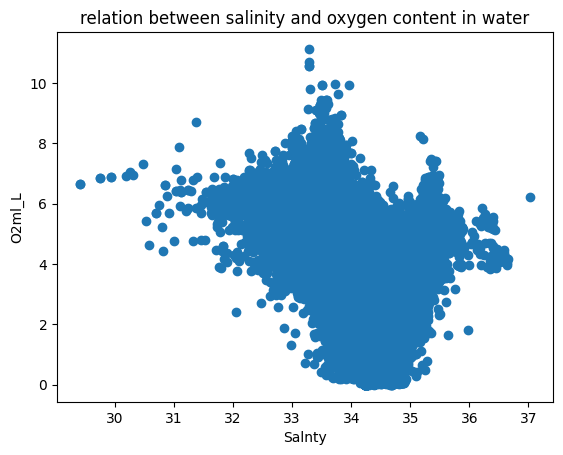

In [31]:
# Scatter plot to understand the relation and identify outliers in two variables
plt.scatter(bottle_df['Salnty'], bottle_df['O2ml_L'])
plt.xlabel('Salnty')
plt.ylabel('O2ml_L')
plt.title('relation between salinity and oxygen content in water')
plt.show()

## Constructing, Training, and making predictions using the BNN model

In [62]:
# Prepare the data
X = bottle_df[['Salnty', 'T_degC']].values
y = bottle_df['O2ml_L'].values

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

In [64]:
# Create an instance of SimpleImputer
imputer = SimpleImputer(strategy='mean')

# Impute NaN values in X
X_imputed = imputer.fit_transform(X)

# Impute NaN values in y
y_imputed = imputer.fit_transform(y.reshape(-1, 1)).flatten()

# Replace the original arrays with the imputed values
X = X_imputed
y = y_imputed

In [65]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [66]:
# Convert numpy arrays to PyTorch tensors
X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()
y_train = torch.from_numpy(y_train).float().view(-1, 1)
y_test = torch.from_numpy(y_test).float().view(-1, 1)

In [79]:
# Define the Bayesian neural network model
class BNN(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(BNN, self).__init__()
        self.linear1 = bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=in_dim, out_features=64)
        self.batch_norm1 = nn.BatchNorm1d(64)  # Batch normalization layer
        self.dropout1 = nn.Dropout(0.2)  # Dropout layer
        self.hidden_layer1 = nn.Linear(64, 128)  # Additional hidden layer
        self.batch_norm2 = nn.BatchNorm1d(128)  # Batch normalization layer
        self.dropout2 = nn.Dropout(0.2)  # Dropout layer
        self.hidden_layer2 = nn.Linear(128, 128)  # Additional hidden layer
        self.linear2 = bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=128, out_features=out_dim)

    def forward(self, x):
        x = self.linear1(x)
        x = self.batch_norm1(x)
        x = self.dropout1(x)
        x = self.hidden_layer1(x)
        x = self.batch_norm2(x)
        x = self.dropout2(x)
        x = self.hidden_layer2(x)
        x = self.linear2(x)
        return x

In [80]:
# Create an instance of the BNN model
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]
model = BNN(input_dim, output_dim)

# increasing complexity of the model for better performance
# model.add_module('hidden_layer', nn.Linear(64, 64))
# model.add_module('hidden_layer', nn.Linear(64, 64))
# model.add_module('hidden_layer', nn.Linear(64, 64))

# Define the loss function
criterion = nn.MSELoss()


In [81]:
# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [82]:
# Set the number of training epochs
num_epochs = 10000

In [ ]:
# Train the model
model.train()
for epoch in range(num_epochs):
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 50 == 0:
        print(f'Epoch: {epoch+1}/{num_epochs}, Loss: {loss.item()}')


Epoch: 50/10000, Loss: 19.185134887695312
Epoch: 100/10000, Loss: 8.910687446594238
Epoch: 150/10000, Loss: 2.1479299068450928
Epoch: 200/10000, Loss: 2.9733476638793945
Epoch: 250/10000, Loss: 2.4286749362945557
Epoch: 300/10000, Loss: 3.693578004837036
Epoch: 350/10000, Loss: 1.2850079536437988
Epoch: 400/10000, Loss: 1.448743224143982
Epoch: 450/10000, Loss: 1.8553121089935303


In [49]:
# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    predictions = model(X_test)


In [50]:
# Convert the predictions and ground truth back to numpy arrays
predictions = predictions.numpy()
y_test = y_test.numpy()

In [51]:
# Print the predictions and ground truth values
print('Predictions:', predictions)
print('Ground Truth:', y_test)

Predictions: [[6.4699397]
 [6.478177 ]
 [6.244271 ]
 ...
 [6.5732274]
 [8.263349 ]
 [5.751018 ]]
Ground Truth: [[10.25 ]
 [ 3.76 ]
 [ 5.27 ]
 ...
 [ 9.69 ]
 [ 9.24 ]
 [ 5.574]]


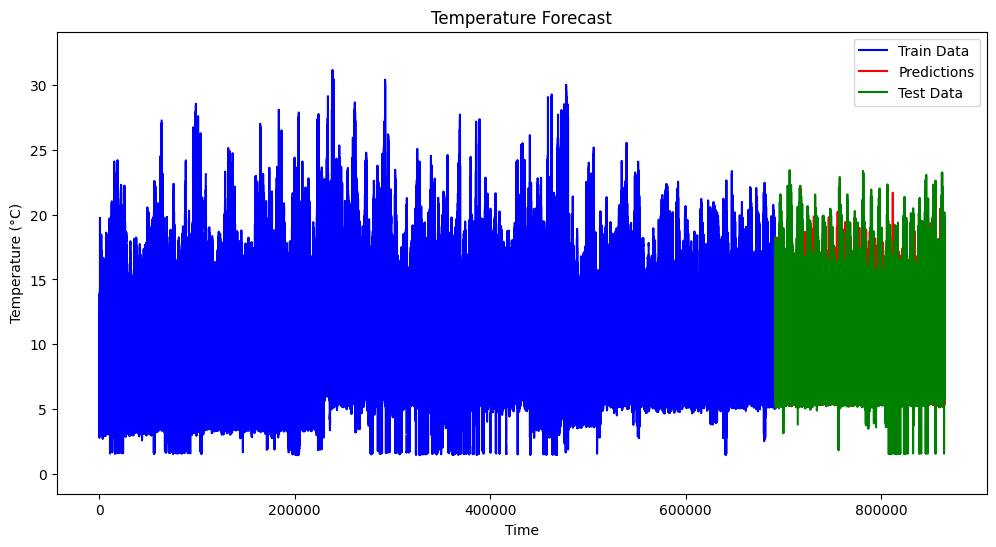

In [53]:
# Prepare the data
total_data = bottle_df['O2ml_L']
train_data = total_data[:len(X_train)]
test_data = total_data[len(X_train):]

# Plotting the train data
plt.figure(figsize=(12, 6))
plt.plot(range(len(train_data)), train_data, color='blue', label='Train Data')

# Plotting the test data and predictions
plt.plot(range(len(train_data), len(train_data) + len(predictions)), predictions, color='red', label='Predictions')
plt.plot(range(len(train_data), len(train_data) + len(test_data)), test_data, color='green', label='Test Data')

# Setting the plot labels and title
plt.xlabel('Time')
plt.ylabel('milliliters of oxygen per liter of seawater ')
plt.title('milliliters of oxygen per liter of seawater Forecast')

# Adding a legend
plt.legend()

# Adjusting y-axis limits for better separation
y_min = min(min(train_data), min(predictions), min(test_data))
y_max = max(max(train_data), max(predictions), max(test_data))
y_range = y_max - y_min
plt.ylim(y_min - 0.1*y_range, y_max + 0.1*y_range)

# Display the plot
plt.show()